# Определение возраста покупателей

**Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:**
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

**Построим модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.**

## Исследовательский анализ данных

In [1]:
!pip install --upgrade scikit-learn -q

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
#import phik
import math
import re
#import shap
#import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from statsmodels.tsa.seasonal import seasonal_decompose
#from phik import resources, report
#from phik.report import plot_correlation_matrix
from scipy import stats as st
from scipy.stats import randint, mode
from math import sqrt
from math import factorial
from matplotlib import pyplot as plt
from scipy.stats import binom, norm
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier,  DecisionTreeRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
#from category_encoders import BinaryEncoder
from sklearn.metrics import (
    confusion_matrix, 
    precision_score, 
    recall_score, 
    accuracy_score, 
    r2_score, 
    mean_squared_error, 
    mean_absolute_error,
    roc_auc_score,
    make_scorer,
    f1_score
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from statsmodels.tsa.stattools import adfuller
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#from pmdarima import auto_arima
#from statsmodels.tsa.arima.model import ARIMA
#from imblearn.over_sampling import SMOTE
#import nltk
#from nltk.corpus import stopwords as nltk_stopwords
#nltk.download('stopwords')
#stopwords = list(set(nltk_stopwords.words('english')))
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')
#from nltk.stem import WordNetLemmatizer
#from nltk.corpus import wordnet
#nltk.download('wordnet')
#nltk.download('omw-1.4')
#from sklearn.feature_extraction.text import TfidfVectorizer
#from pymystem3 import Mystem
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

In [3]:
data_labels = pd.read_csv('/datasets/faces/labels.csv')

In [4]:
def inf(df, r):
    df1=df.head(r)
    df2=df.info()
    return display(df1, df2)

In [5]:
inf(data_labels, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


None

In [6]:
data_labels.duplicated().sum()

0

**Данные загружены, соответствуют описанию, типы данных в порядке, пропусков и дубликатов в данных нет. Переходим к анализу.**

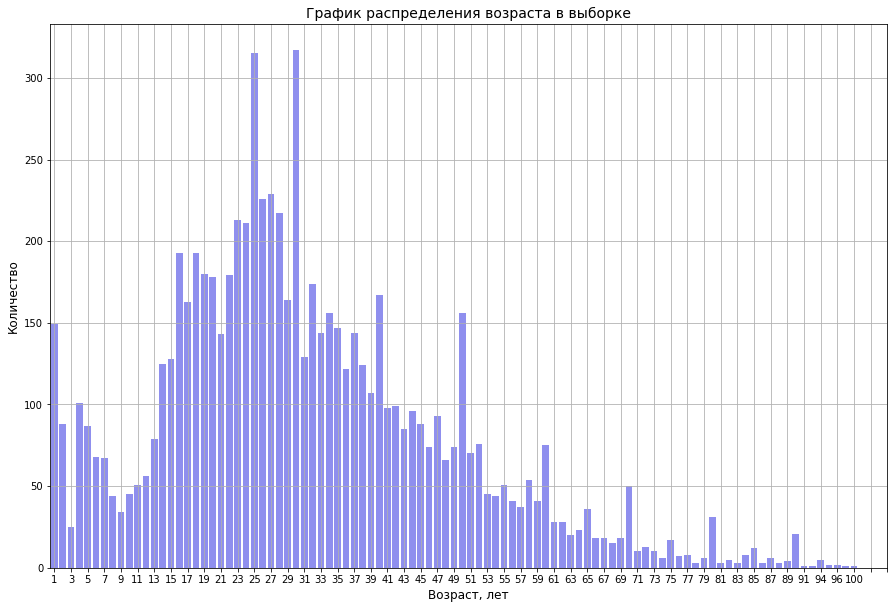

In [7]:
fig, ax = plt.subplots(figsize=(15,10))
sns.countplot(x=data_labels['real_age'], ax=ax, color='blue', alpha=0.5)
ax.set_title(f'График распределения возраста в выборке', fontsize=14)
ax.set_ylabel('Количество', fontsize=12)
ax.set_xlabel(f'Возраст, лет', fontsize=12)
ax.set_xticks(range(0, 101, 2))
ax.grid(True) 

**На графике видим мультимодальность. Первый пик видим в детском возрасте (первые годы жизни), а потом в районе 25-30 лет. Вероятно это может быть связано с различными местами и способами сбора информации разных возрастных групп. Данных старше 70 лет довольно мало, что может несколько ослабить результативность обучения в этой возрастной группе. Для увеличения количества входных данных будем использовать аугментацию.**

Found 7591 validated image filenames.


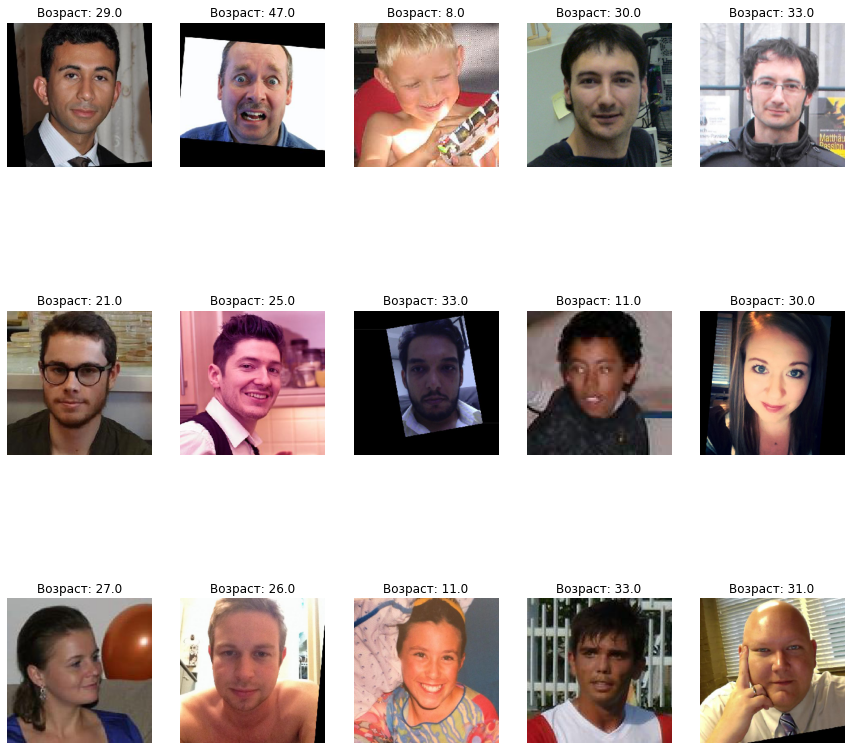

In [8]:
datagen = ImageDataGenerator(rescale=1./255)

generator = datagen.flow_from_dataframe(
    dataframe=data_labels,
    directory='/datasets/faces/final_files',
    x_col='file_name',
    y_col='real_age',
    batch_size=32,
    class_mode='raw',  
    shuffle=True
)

images, labels = next(generator)
num_images_to_display = 15

plt.figure(figsize=(15, 15))
for i in range(num_images_to_display):
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(images[i])
    plt.title(f"Возраст: {labels[i]:.1f}")  # Отображаем возраст
    plt.axis("off")

plt.show()

**В ходе выполнения исследовательского анализа была проведена проверка данных на соответствие типов данных, а также наличие пропусков и распределение по возрастам.**

**По результатам проведенного анализа можем сделать следующие выводы:**
- имеем достаточно большой объём данных для обучения с диапазоном возрастов от рождения до 100 лет. Данных старше 70 лет довольно мало, что может несколько ослабить результативность обучения в этой возрастной группе. Для увеличения количества входных данных будем использовать аугментацию, а также предобученную сеть.
- видим фотографии различного качества, с различным ракурсом, стилем, с большим разнообразием лиц, освещения и поз.
- исходя из полученных наблюдений принимаем решение, что для построения модели будем использовать ResNet, так как она обладает глубокой архитектурой (глубокие сети могут лучше различать тонкие детали, которые могут быть важны для определения возраста, такие как морщины, текстура кожи и другие возрастные признаки), она универсальна и адаптивна, а также способна обрабатывать сложные данные, что делает её подходящей для этой задачи, так как определение возраста по фотографии может быть сложной задачей из-за разнообразия лиц, освещения и поз.

## Обучение модели

**Код для обучения модели:**

```python

import numpy as np
import pandas as pd
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.regularizers import l2

def load_train(path):
    df = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
    )
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = df,
        directory = path + 'final_files',
        x_col = 'file_name',
        y_col = 'real_age',
        class_mode = 'raw',
        target_size = (150,150),
        batch_size = 32,
        subset='training',
        seed=12345
    )
    return train_datagen_flow
 
def load_test(path):
    df = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)                                

    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe = df,
        directory = path + 'final_files',
        x_col = 'file_name',
        y_col = 'real_age',
        class_mode = 'raw',
        target_size = (150,150),
        batch_size = 32,
        subset='validation',
        seed=12345
    )
    return test_datagen_flow
 

def create_model(input_shape):
    optimizer = Adam(lr=0.0001) 
    
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False) 
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())  
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=7, steps_per_epoch=None, validation_steps=None):
    
    model.fit(train_data, validation_data=test_data, batch_size=batch_size, epochs=epochs, 
              steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, verbose=2)
 
    return model

```

**Результат данного кода ниже. Длинные строки со скачиванием модели удалены.**

```


Found 5694 validated image filenames.
Found 1897 validated image filenames.



Train for 178 steps, validate for 60 steps
Epoch 1/7
2025-04-21 20:59:08.517298: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-04-21 20:59:08.970352: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 88s - loss: 285.7425 - mae: 12.2893 - val_loss: 559.8519 - val_mae: 18.6455
Epoch 2/7
178/178 - 79s - loss: 115.1403 - mae: 8.1148 - val_loss: 632.0104 - val_mae: 20.1422
Epoch 3/7
178/178 - 78s - loss: 93.7200 - mae: 7.3769 - val_loss: 396.9492 - val_mae: 14.8664
Epoch 4/7
178/178 - 78s - loss: 81.3413 - mae: 6.8418 - val_loss: 147.8087 - val_mae: 9.3247
Epoch 5/7
178/178 - 77s - loss: 74.4770 - mae: 6.5817 - val_loss: 94.0106 - val_mae: 7.2713
Epoch 6/7
178/178 - 78s - loss: 65.0740 - mae: 6.1551 - val_loss: 89.3742 - val_mae: 6.9772
Epoch 7/7
178/178 - 78s - loss: 57.8672 - mae: 5.8575 - val_loss: 79.6590 - val_mae: 6.6376
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 11s - loss: 79.6590 - mae: 6.6376

Задание выполнено верно


```

## Анализ обученной модели

**Наша цель достигнута. Была обучена модель, которая определяет возраст по фотографии с требуемой точностью, при этом с минимальными временными затратами на работу модели, нам хватило 7 эпох.  Значение MAE на тестовой выборке 6.6376, что меньше требуемых 8. По логам видим, что наша цель была бы достигнута за 5 эпох, что ещё более ускорило бы работу модели, однако это не критично и из-за длинных очередей на обучение моделей далее менять модель не стал.**

**Можно рекомендовать заказчику использование данной модели для обработки фотографий покупателей с целью определения возраста.**

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы